In [111]:
import pandas as pd
train_df = pd.read_csv('titanic/train.csv')
test_df = pd.read_csv('titanic/test.csv')
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [155]:
train_df.loc[train_df["Cabin"].str.startswith("B", na=False)].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0000,B28,NaN
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C
139,140,0,1,"Giglio, Mr. Victor",male,24.0,0,0,PC 17593,79.2000,B86,C


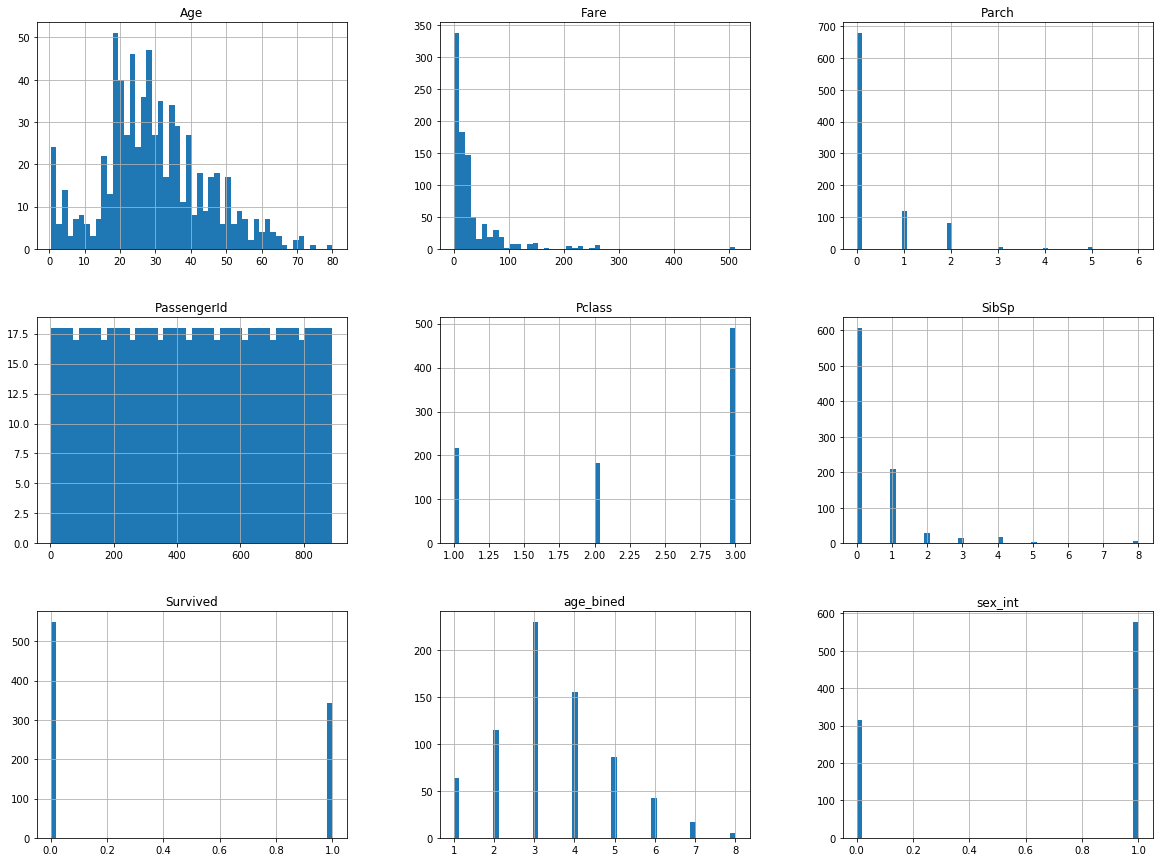

In [101]:
%matplotlib	inline
import matplotlib.pyplot as plt
import numpy as np
train_df["sex_int"] = train_df["Sex"] == "male"
train_df["age_bined"] = np.ceil(train_df["Age"] / 10.0)
train_df.hist(bins=50, figsize=(20, 15))
plt.show()
train_df.drop('sex_int', axis=1, inplace=True)
train_df.drop('age_bined', axis=1, inplace=True)
pass

In [157]:
df = train_df.copy()

#df.dropna(subset=["Age"])
df["sex_int"] = np.where(df["Sex"] == "male", 1.0, 0.0)    
#train_df["is_baby"] = np.where(train_df["Age"] <= 5.0, 1.0, 0.0)
df["male_class1"] = (df["Sex"] == "male") & (df["Pclass"] == 1)
df["male_class2"] = (df["Sex"] == "male") & (df["Pclass"] == 2)
df["male_class3"] = (df["Sex"] == "male") & (df["Pclass"] == 3)
df["female_class1"] = (df["Sex"] == "female") & (df["Pclass"] == 1)
df["female_class2"] = (df["Sex"] == "female") & (df["Pclass"] == 2)
df["female_class3"] = (df["Sex"] == "female") & (df["Pclass"] == 3)

df["cab_A"] = np.where(df["Cabin"].str.startswith('A', na=False), 1.0, 0.0)
df["cab_B"] = np.where(df["Cabin"].str.startswith('B', na=False), 1.0, 0.0)
df["cab_C"] = np.where(df["Cabin"].str.startswith('C', na=False), 1.0, 0.0)
df["cab_D"] = np.where(df["Cabin"].str.startswith('D', na=False), 1.0, 0.0)
df["cab_E"] = np.where(df["Cabin"].str.startswith('E', na=False), 1.0, 0.0)
df["cab_F"] = np.where(df["Cabin"].str.startswith('F', na=False), 1.0, 0.0)
df["cab_G"] = np.where(df["Cabin"].str.startswith('G', na=False), 1.0, 0.0)
df["cab_NaN"] = np.where(df["Cabin"].notnull(), 0.0, 1.0)
df["title_Mr"] = np.where(df["Name"].str.contains("Mr.",), 1.0, 0.0)
df["title_Dr"] = np.where(df["Name"].str.contains("Dr.",), 1.0, 0.0)
df["title_Ms"] = np.where(df["Name"].str.contains("Miss.",), 1.0, 0.0)
df["title_Mrs"] = np.where(df["Name"].str.contains("Mrs.",), 1.0, 0.0)
df["title_Master"] = np.where(df["Name"].str.contains("Master.",), 1.0, 0.0)
df = pd.concat([df, pd.get_dummies(train_df.Embarked)], axis=1)

age_bins = [
    (20, [0, 5, 20, 40, 60, 80]),
    #(10, [0, 10, 20, 30, 40, 50, 60, 70, 80]),
    #(5, [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80])
]

for id, bins in age_bins:
    bins_df = pd.get_dummies(pd.cut(train_df.Age, bins, include_lowest=True), prefix=str(id))
    for age_bin_col in bins_df:
        df = pd.concat([df, bins_df[age_bin_col]], axis=1)
        for sex in range(0, 2):
            df["{}_sex_{}".format(age_bin_col, sex)] = np.where((df["sex_int"] == sex) & (df[age_bin_col] == 1), 1.0, 0.0)
            for cl in range(1, 4):
                df["{}_sex_{}_class_{}".format(age_bin_col, sex, cl)] = np.where((df["sex_int"] == sex) & (df[age_bin_col] == 1) & (df["Pclass"] == cl), 1.0, 0.0)
                
            
        # df["{}_male".format(age_bin_col)] = np.where((df["Sex"] == "male") & (df[age_bin_col] == 1), 1.0, 0.0)
        # df["{}_female".format(age_bin_col)] = np.where((df["Sex"] == "female") & (df[age_bin_col] == 1), 1.0, 0.0)
        # for cl in range(1, 3):
        #     df["{}_male_class_{}".format(age_bin_col)] = np.where((df["Sex"] == "male") & (df[age_bin_col] == 1), 1.0, 0.0)
        #     df["{}_female_class_{}".format(age_bin_col)] = np.where((df["Sex"] == "female") & (df[age_bin_col] == 1), 1.0, 0.0)
        
        #df = pd.concat([df, (bins_df[age_bin_col] )], axis=1)
    #df = pd.concat([df, bins_df], axis=1)


print("Correlations for Survived:")
print(df.corr()["Survived"].sort_values(ascending=False))
print("")
print("Correlations for age:")
print(df.corr()["Age"].sort_values(ascending=False))
print("")
print("Correlations for Cab A:")
print(df.corr()["cab_A"].sort_values(ascending=False))
print("")
print("Correlations for Cab B:")
print(df.corr()["cab_B"].sort_values(ascending=False))
#from pandas.plotting import scatter_matrix
#scatter_matrix(df[["Fare", "Age"]], figsize=(12, 8))


Correlations for Survived:
Survived                          1.000000
female_class1                     0.412581
20_(20.0, 40.0]_sex_0             0.351641
title_Mrs                         0.344223
female_class2                     0.337329
title_Ms                          0.327093
20_(20.0, 40.0]_sex_0_class_1     0.281671
Fare                              0.257307
20_(20.0, 40.0]_sex_0_class_2     0.250055
20_(40.0, 60.0]_sex_0_class_1     0.196544
20_(40.0, 60.0]_sex_0             0.176284
cab_B                             0.175095
C                                 0.168240
20_(5.0, 20.0]_sex_0_class_1      0.154169
cab_D                             0.150716
20_(-0.001, 5.0]                  0.150304
20_(5.0, 20.0]_sex_0              0.147440
cab_E                             0.145321
20_(5.0, 20.0]_sex_0_class_2      0.141654
20_(-0.001, 5.0]_sex_0            0.120780
20_(-0.001, 5.0]_sex_1_class_2    0.120597
20_(40.0, 60.0]_sex_0_class_2     0.115675
cab_C                      

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np


class ExtractCabinBlock(BaseEstimator, TransformerMixin):
    def __init__(self, field_name):
        self.field_name = field_name
        self.blocks = {"A": 0,
                       "B": 1,
                       "C": 2,
                       "D": 3,
                       "E": 4,
                       "F": 5,
                       "G": 6,
                       "H": 7,
                       "K": 8,
                       "T": 9}
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None):
        source = X[self.field_name]
        block_col = np.empty((len(source), 11), dtype=int)
        #seat_col = np.empty((len(source), 11), dtype=int)
        block_col[:, :] = 0
        #seat_col[:, :] = np.nan
        for i in range(0, len(source)):
            x = source[i]
            target = block_col[i]
            if pd.isnull(x):
                target[10] = 1
                continue
            splitted = x.split(" ")
            seats = np.empty((len(splitted), 2), dtype=object)
            for j in range(0, len(splitted)):
                cabin_seat = splitted[j]
                cabin_seat_number = cabin_seat[1:]
                if not cabin_seat_number:
                    cabin_seat_number = np.nan
                else:
                    cabin_seat_number = int(cabin_seat_number)
                seats[j] = [self.blocks[cabin_seat[0]], cabin_seat_number]
            for block in seats[:, 0]:
                target[block] = 1

        return block_col
        #return X[[self.field_name]].fillna("NaN").values


class FareImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.means = {}

    def fit(self, X, y=None, **fit_params):
        for key, class_group in train_df.groupby(["Pclass"]):
            self.means[key] = class_group.Fare.mean()
        return self

    def transform(self, X):
        for idx, row in X.iterrows():
            if row["Fare"] == 0.0:
                row["Fare"] = self.means[row["Pclass"]]
        return X[["Fare"]].values


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names, fill_na=None):
        self.attribute_names = attribute_names
        self.fill_na = fill_na
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X):
        if not self.fill_na:
            return X[self.attribute_names].values
        return X[self.attribute_names].fillna(self.fill_na).values


class LabelBinarizerX(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None,**fit_params):
        return self
    def transform(self, X):
        return LabelBinarizer().fit(X).transform(X)


# e = FillEmbarkedNa("Embarked")
# b = LabelBinarizer()
# b.fit_transform(e.fit_transform(train_df))

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelBinarizer, Imputer

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(["Pclass", "Age", "SibSp", "Parch"])),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler())
    ])

fare_pipeline = Pipeline([
        ('selector', FareImputer()),
        ('std_scaler', StandardScaler())
    ])

embarked_pipeline = Pipeline([
        ('selector', DataFrameSelector(["Embarked"], "NaN")),
        ('cat_encoder', LabelBinarizerX())
    ])

sex_pipeline = Pipeline([
        ('selector', DataFrameSelector(["Sex"])),
        ('cat_encoder', LabelBinarizerX())
    ])

cabin_pipeline = Pipeline([
        ('selector', ExtractCabinBlock("Cabin")),
        #('cat_encoder', LabelBinarizerX())
    ])

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer, Binarizer

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(["Pclass", "c_1", "c_2", "c_3", "c_4", "c_5", "c_6", "c_7", "c_8"])),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler())
    ])

final_transform = FeatureUnion(transformer_list=[
        ("embarked_pipeline", embarked_pipeline),
        ("num_pipeline", num_pipeline),
        ("sex_pipeline", sex_pipeline),
        ("cabin_pipeline", cabin_pipeline),
        ("fare_pipeline", fare_pipeline)
    ])

y_train = train_df.Survived.values
# c, r = y_train.shape
# y_train = y_train.reshape(c,)

#final_pipeline = Pipeline([
#        ('transformer', final_transform),
#        ('predictor', LogisticRegression())
#    ])

#predictor = LogisticRegression()

train_df["is_child_1"] = (train_df["Age"] < 10)
train_df["is_male"] = (train_df["Age"] > 30) & (train_df["Sex"] == "male") & (train_df["Pclass"] > 1)

#scores = cross_val_score(final_pipeline, train_df, train_df.Survived, scoring="accuracy", cv=5)
#np.median(scores)
X_train = final_transform.fit_transform(train_df, train_df.Survived)
print(cross_val_score(MLPClassifier(hidden_layer_sizes=(20, 20)), X_train, y_train, cv=10, scoring="accuracy").mean())
#print(cross_val_score(LogisticRegression(), X_train, y_train, cv=8, scoring="accuracy").mean())

KeyError: "['c_1' 'c_2' 'c_3' 'c_4' 'c_5' 'c_6' 'c_7' 'c_8'] not in index"

In [18]:
for i, r in train_df.iterrows():
    print(r["Fare"] == np.nan)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
